### Cryptopunk Image Classifier

In [1]:
from urllib.request import Request, urlopen

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Input, Dropout
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from gazpacho import Soup

from utils import macro_soft_f1, macro_f1, learning_curves

Download the 10K Punk Image:

In [2]:
url = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
img = Image.open(urlopen(url))

Quick check:

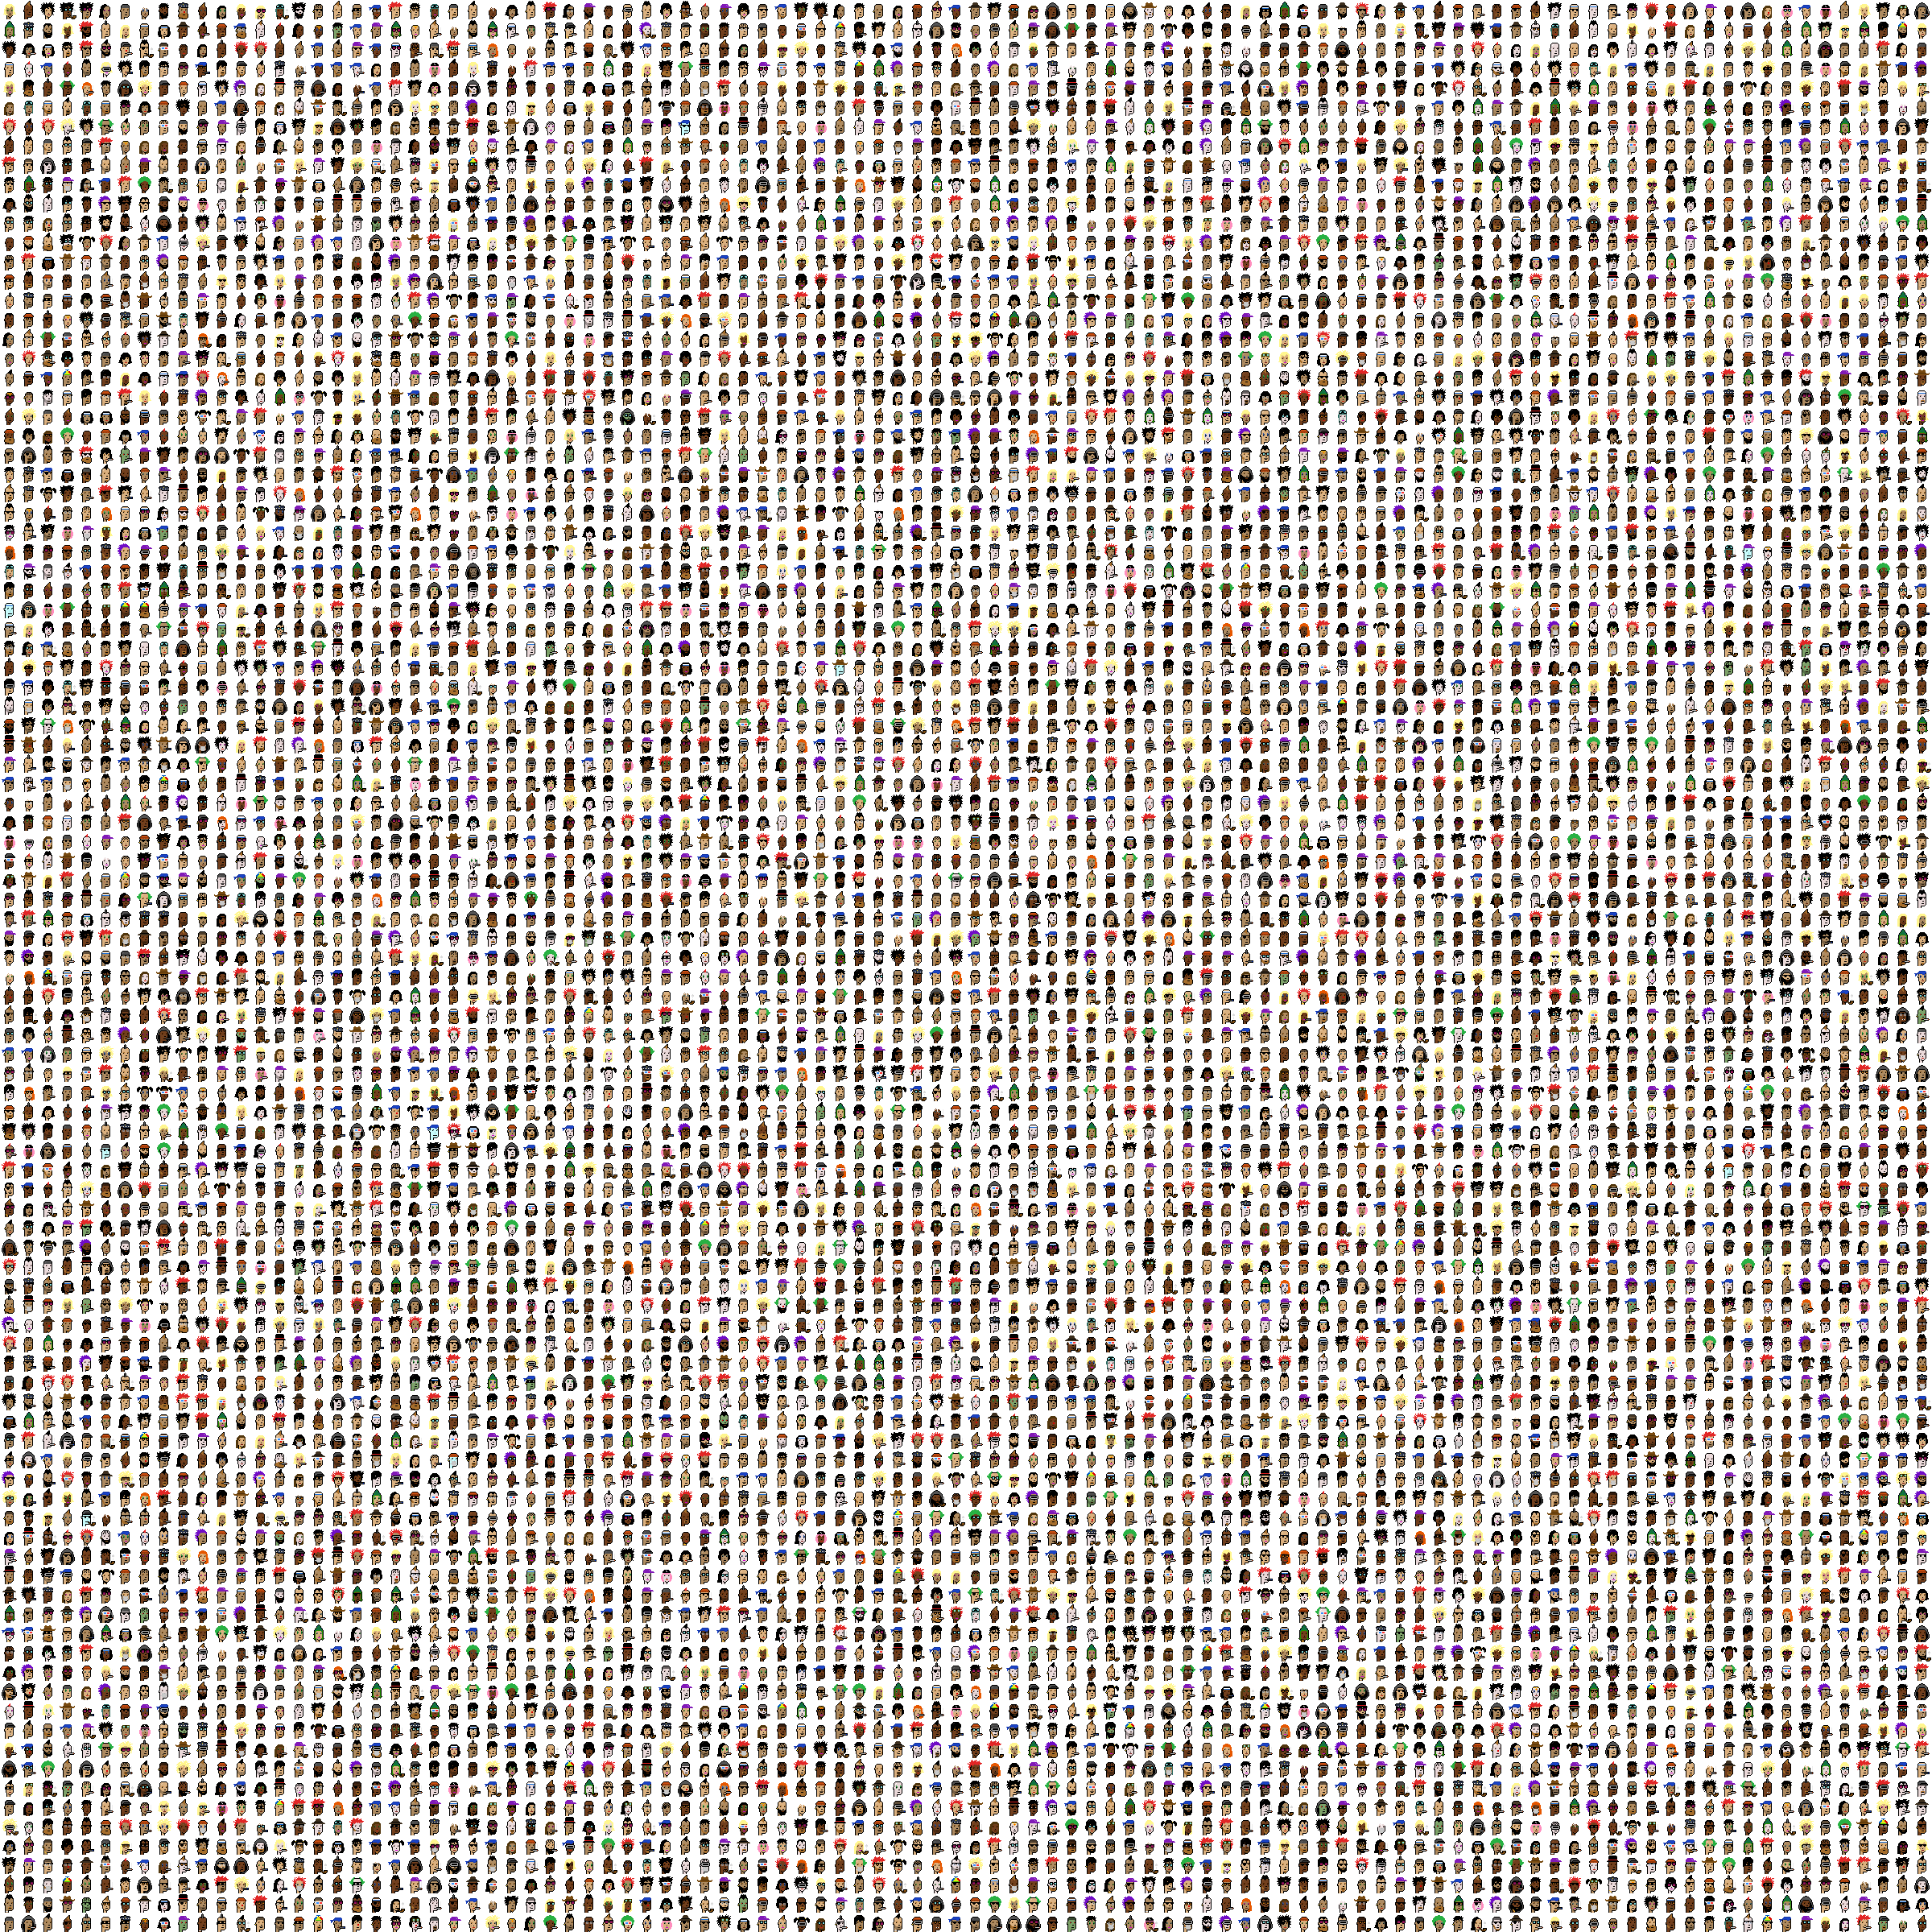

In [3]:
img

Make sure cropping works at 24x24:

In [4]:
print(img.height)
print(img.width)
img.crop((0, 0, 24, 24))

2400
2400


Try another one:

In [5]:
x = column = 30
y = row = 57
id = x + (y * 100)
left = x * 24
upper = y * 24
right = (x + 1) * 24
lower = (y + 1) * 24

In [6]:
box = (left, upper, right, lower)

In [7]:
img.crop(box)

Crop and export of each punk individually:

In [8]:
for y in tqdm(range(0, 100)):
    for x in range(0, 100):
        i = x + (y * 100)
        left = x * 24
        upper = y * 24
        right = (x + 1) * 24
        lower = (y + 1) * 24
        box = (left, upper, right, lower)
        punk = img.crop(box)
        punk.save(f"images/{i}.png")

100%|██████████| 100/100 [00:04<00:00, 20.56it/s]


Load scraped attribute data:

In [9]:
df = pd.read_csv("data/attributes.csv")
df.sample(10)

,id,attributes
8719,8719,Female + Tassle Hat + Blue Eye Shadow + Hot Li...
2421,2421,Male + Vape + Headband + Smile
692,692,Male + Frumpy Hair + Eye Mask
2896,2896,Female + Blue Eye Shadow + Earring + Straight ...
5694,5694,Male + Shadow Beard + Mohawk + Small Shades
3818,3818,Female + Headband + Clown Eyes Blue
8022,8022,Male + Cap + Shadow Beard + Clown Eyes Green
4094,4094,Male + Buck Teeth + Headband + Medical Mask
8857,8857,Zombie + Wild Hair + 3D Glasses
5885,5885,Male + Normal Beard Black + Police Cap + Earri...


In [10]:
Image.open("images/6381.png")

Quick look at attribute frequencies:

In [11]:
label_freq = df['attributes'].apply(lambda s: str(s).split(' + ')).explode().value_counts().sort_values(ascending=False)

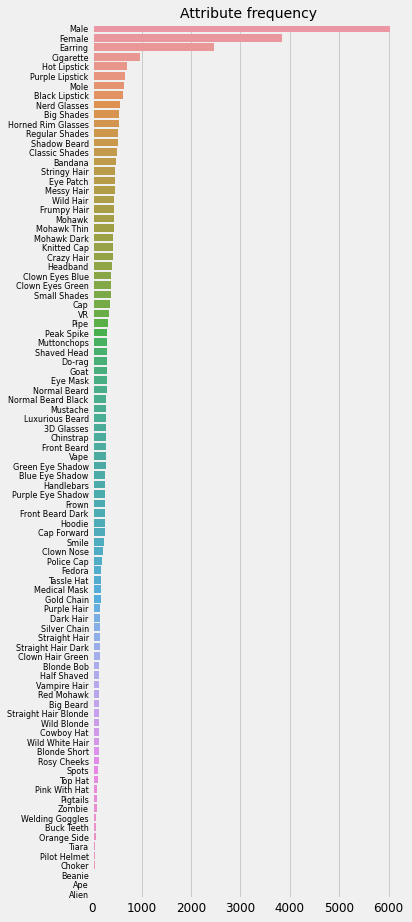

In [12]:
style.use("fivethirtyeight")
plt.figure(figsize=(5,15))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Attribute frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=8)
plt.show()

In [13]:
cut_off = 100
exclude = list(label_freq[label_freq<cut_off].index)
exclude += ["Male", "Female", "Ape", "Alien", "Zombie"] # not an attribute
print("Excluding:", exclude)

Excluding: ['Pink With Hat', 'Pigtails', 'Zombie', 'Welding Goggles', 'Buck Teeth', 'Orange Side', 'Tiara', 'Pilot Helmet', 'Choker', 'Beanie', 'Ape', 'Alien', 'Male', 'Female', 'Ape', 'Alien', 'Zombie']


Explode attributes into a list:

In [14]:
df['attribute_list'] = df['attributes'].apply(lambda s: [l for l in str(s).split(' + ') if l not in exclude])

Train Test Split the dataframe:

In [15]:
X = df['id'].apply(lambda x: f"./images/{x}.png").values.tolist()
Y = df['attribute_list'].values.tolist()

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
print(X_train[0], Y_train[0])

./images/9254.png ['Shadow Beard', 'Clown Hair Green', 'Eye Patch']


In [18]:
Image.open(X_train[0])

Make sure labels and images are lined up properly:

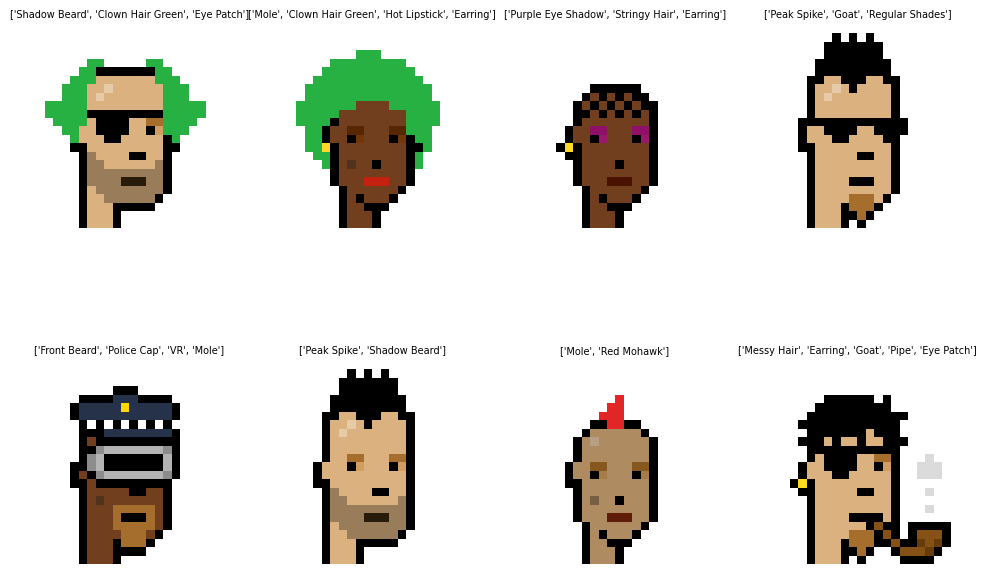

In [19]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(Y_train[i], size=7)
    plt.axis('off')

Binarize the **Y** array:

In [20]:
mlb = MultiLabelBinarizer()
mlb.fit(Y_train)
N_LABELS = len(mlb.classes_)

print("Labels:")
for (i, label) in enumerate(mlb.classes_):
    print(f"{i}. {label}")

Labels:
0. 3D Glasses
1. Bandana
2. Big Beard
3. Big Shades
4. Black Lipstick
5. Blonde Bob
6. Blonde Short
7. Blue Eye Shadow
8. Cap
9. Cap Forward
10. Chinstrap
11. Cigarette
12. Classic Shades
13. Clown Eyes Blue
14. Clown Eyes Green
15. Clown Hair Green
16. Clown Nose
17. Cowboy Hat
18. Crazy Hair
19. Dark Hair
20. Do-rag
21. Earring
22. Eye Mask
23. Eye Patch
24. Fedora
25. Front Beard
26. Front Beard Dark
27. Frown
28. Frumpy Hair
29. Goat
30. Gold Chain
31. Green Eye Shadow
32. Half Shaved
33. Handlebars
34. Headband
35. Hoodie
36. Horned Rim Glasses
37. Hot Lipstick
38. Knitted Cap
39. Luxurious Beard
40. Medical Mask
41. Messy Hair
42. Mohawk
43. Mohawk Dark
44. Mohawk Thin
45. Mole
46. Mustache
47. Muttonchops
48. Nerd Glasses
49. Normal Beard
50. Normal Beard Black
51. Peak Spike
52. Pipe
53. Police Cap
54. Purple Eye Shadow
55. Purple Hair
56. Purple Lipstick
57. Red Mohawk
58. Regular Shades
59. Rosy Cheeks
60. Shadow Beard
61. Shaved Head
62. Silver Chain
63. Small Shades

Transform:

In [21]:
Y_mlb_train = mlb.transform(Y_train)
Y_mlb_test = mlb.transform(Y_test)

Print some examples:

In [22]:
for i in range(3):
    print(X_train[i], Y_mlb_train[i])

./images/9254.png [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
./images/1561.png [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
./images/1670.png [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0]


TensorFlow parse function:

In [23]:
IMG_SIZE = 24 # Specify height and width of the image
CHANNELS = 3 # Keep RGB color channels

def parse_function(filename, label):
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

Create Dataset function for TF Model:

In [24]:
BATCH_SIZE = 512
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [25]:
def create_dataset(filenames, labels):    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [26]:
D_train = create_dataset(X_train, Y_mlb_train)
D_test = create_dataset(X_test, Y_mlb_test)

In [27]:
for f, l in D_train.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (512, 24, 24, 3)
Shape of labels array: (512, 78)


Build a simple ConvNet:

In [28]:
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS)),
    Conv2D(32, activation="relu", kernel_size=(3, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, activation="relu", kernel_size=(3, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, activation="relu", kernel_size=(3, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(1/4),
    Dense(N_LABELS, activation='sigmoid')
])

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=macro_soft_f1,
    metrics=[macro_f1]
)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [ ]:
filepath = "./models/punk_classifier_live"

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        save_weights_only=False,
        monitor='val_macro_f1',
        mode='max',
        save_best_only=True
    )
]

In [ ]:
history = model.fit(D_train, epochs=500, validation_data=D_test, callbacks=callbacks)

In [ ]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

In [ ]:
model.evaluate(D_test)

Reload:

In [31]:
filepath = "./models/punk_classifier"

model = tf.keras.models.load_model(
    filepath, 
    custom_objects={"macro_f1": macro_f1, "macro_soft_f1": macro_soft_f1}
)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [33]:
for X, Y_mlb in D_test.take(1):
    print(model.predict(X))

[[1.01708174e-07 2.39774995e-15 1.98539865e-11 ... 5.73859114e-18
  1.64946521e-13 4.14159724e-15]
 [2.47424867e-12 4.71473777e-06 4.36378897e-08 ... 1.46705005e-14
  2.34584685e-10 8.45381545e-13]
 [1.86079863e-08 1.55763080e-09 1.95225036e-09 ... 3.77565598e-17
  6.86514376e-14 6.97296821e-12]
 ...
 [1.13657337e-14 4.29199387e-14 3.80343808e-18 ... 1.91057732e-19
  1.00000000e+00 5.07581094e-20]
 [5.36768230e-09 9.79797465e-10 1.99606859e-07 ... 2.27781241e-15
  1.08183885e-05 3.61878252e-13]
 [2.27370640e-11 5.53705167e-26 1.30104770e-12 ... 3.08265159e-29
  1.50194875e-18 8.97738856e-24]]


Need a better predict function:

In [34]:
punk = 502
img_path = f'./images/{punk}.png'

# Read and prepare image
img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
img = image.img_to_array(img)
img = img/255
img = np.expand_dims(img, axis=0)

# Generate prediction
prediction = (model.predict(img) > 0.5).astype('int')
prediction = pd.Series(prediction[0])
prediction.index = mlb.classes_
prediction = prediction[prediction==1].index.values
print(prediction)

['Earring' 'Headband' 'Normal Beard']


In [35]:
Image.open(f"images/{punk}.png")

Peek at the predictions:

In [36]:
prediction = model.predict(img)
prediction = pd.Series(prediction[0])
prediction.index = mlb.classes_

In [37]:
prediction.sort_values(ascending=False).head(10)

Normal Beard        1.000000e+00
Headband            9.999995e-01
Earring             9.985676e-01
Shadow Beard        2.327052e-08
Front Beard Dark    4.291276e-09
Rosy Cheeks         1.958875e-09
Frown               1.670112e-09
Cap                 5.868218e-10
Do-rag              3.215911e-10
Muttonchops         1.581248e-10
dtype: float32

Scrape to predict pipeline:

In [38]:
punk = 1000
padded = str(punk).zfill(4)
url = f"https://www.larvalabs.com/public/images/cryptopunks/punk{padded}.png"

In [39]:
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
asset = urlopen(req)
img = Image.open(asset)
img = img.convert('RGB') # three chanels
img = img.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
img = image.img_to_array(img)
img = img.reshape(1, 24, 24, 3)

In [40]:
prediction = (model.predict(img) > 0.5).astype('int')
prediction = pd.Series(prediction[0])
prediction.index = mlb.classes_
prediction = prediction[prediction==1].index.values
print(prediction)

['Cigarette' 'Dark Hair' 'Mole']
